# Libraries

In [18]:
# Importing relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Sampler
from imblearn.over_sampling import SMOTENC, SMOTE
from imblearn.under_sampling import RandomUnderSampler

# modelling packages
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# model evaluation
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_predict, cross_val_score
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score, accuracy_score, confusion_matrix
from sklearn.metrics import classification_report

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

# EDA 

## Explore Categorical Features

## Explore Numerical Features

## Explore Target Variable

## Relationship between Features and Target

# Data Engineering

## Explore and manage missing values

## Train Test Split

In [7]:
df = pd.read_csv('dataset/bank-additional-full.csv', sep=';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [8]:
y_clean = df['y'].replace({'yes': 1, 'no': 0})
X_clean = df.drop(columns=['y'])

In [9]:
NumCols = X_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()
CatCols = X_clean.select_dtypes(include=['object']).columns.tolist()

In [27]:
# Split the training set into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, stratify=y_clean, test_size=0.2, random_state=42
)


## Data Preprocessing

In [28]:
# Identify categorical columns (indices)
categorical_features = X_clean.select_dtypes(include=['object', 'category']).columns
categorical_indices = [X_clean.columns.get_loc(col) for col in categorical_features]

In [ ]:
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), NumCols),  # Numerical columns
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), CatCols)  # Categorical columns
], remainder='passthrough')

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)


### Sampling Method 1 - SMOTE-NC

In [30]:
# Initialize SMOTE-NC
smote_nc = SMOTENC(categorical_features=categorical_indices, sampling_strategy='auto', k_neighbors=5, random_state=42)

# Fit and resample
X_train_smote_nc, y_smote_nc = smote_nc.fit_resample(X_train, y_train)

### Sampling Method 2 - SMOTE (Synthetic Minority Over-sampling Technique)

In [31]:
# Initialize SMOTE
smote = SMOTE( sampling_strategy='auto', k_neighbors=5, random_state=42)

# Apply SMOTE on processed numeric + one-hot encoded data
X_train_smote, y_train_smote = smote.fit_resample(X_train_processed, y_train)

print("Before SMOTE class distribution:", np.bincount(y_train))
print("After SMOTE class distribution:", np.bincount(y_train_smote))

Before SMOTE class distribution: [29238  3712]
After SMOTE class distribution: [29238 29238]


### Sampling Method 3 - Random Under Sampler

In [32]:
# Initialize RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Apply under-sampling on processed numeric + one-hot encoded data
X_train_rus, y_train_rus = rus.fit_resample(X_train_processed, y_train)

In [33]:
# Initialize RandomOverSampler
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)

# Apply over-sampling on processed numeric + one-hot encoded data
X_train_ros, y_train_ros = ros.fit_resample(X_train_processed, y_train)

NameError: name 'RandomOverSampler' is not defined

### Sampling Method 4 - Class weight adjustment

Use class_weight='balanced' in Logistic Regression and Decision Tree (without resampling).

In [26]:
# Logistic Regression with class weights
lr_weighted = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr_weighted.fit(X_train_processed, y_train)

y_pred_weighted = lr_weighted.predict(X_test_processed)
y_prob_weighted = lr_weighted.predict_proba(X_test_processed)[:, 1]

print("Class-weight Logistic Regression Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred_weighted))
print("Precision:", precision_score(y_test, y_pred_weighted))
print("Recall:", recall_score(y_test, y_pred_weighted))
print("F1-Score:", f1_score(y_test, y_pred_weighted))
print("AUC:", roc_auc_score(y_test, y_prob_weighted))

# Decision Tree with class weights
dt_weighted = DecisionTreeClassifier(class_weight='balanced', random_state=42)
dt_weighted.fit(X_train_processed, y_train)

y_pred_dt_weighted = dt_weighted.predict(X_test_processed)
y_prob_dt_weighted = dt_weighted.predict_proba(X_test_processed)[:, 1]

print("Class-weight Decision Tree Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred_dt_weighted))
print("Precision:", precision_score(y_test, y_pred_dt_weighted))
print("Recall:", recall_score(y_test, y_pred_dt_weighted))
print("F1-Score:", f1_score(y_test, y_pred_dt_weighted))
print("AUC:", roc_auc_score(y_test, y_prob_dt_weighted))


NameError: name 'X_test_processed' is not defined

### Imbalance Plotting

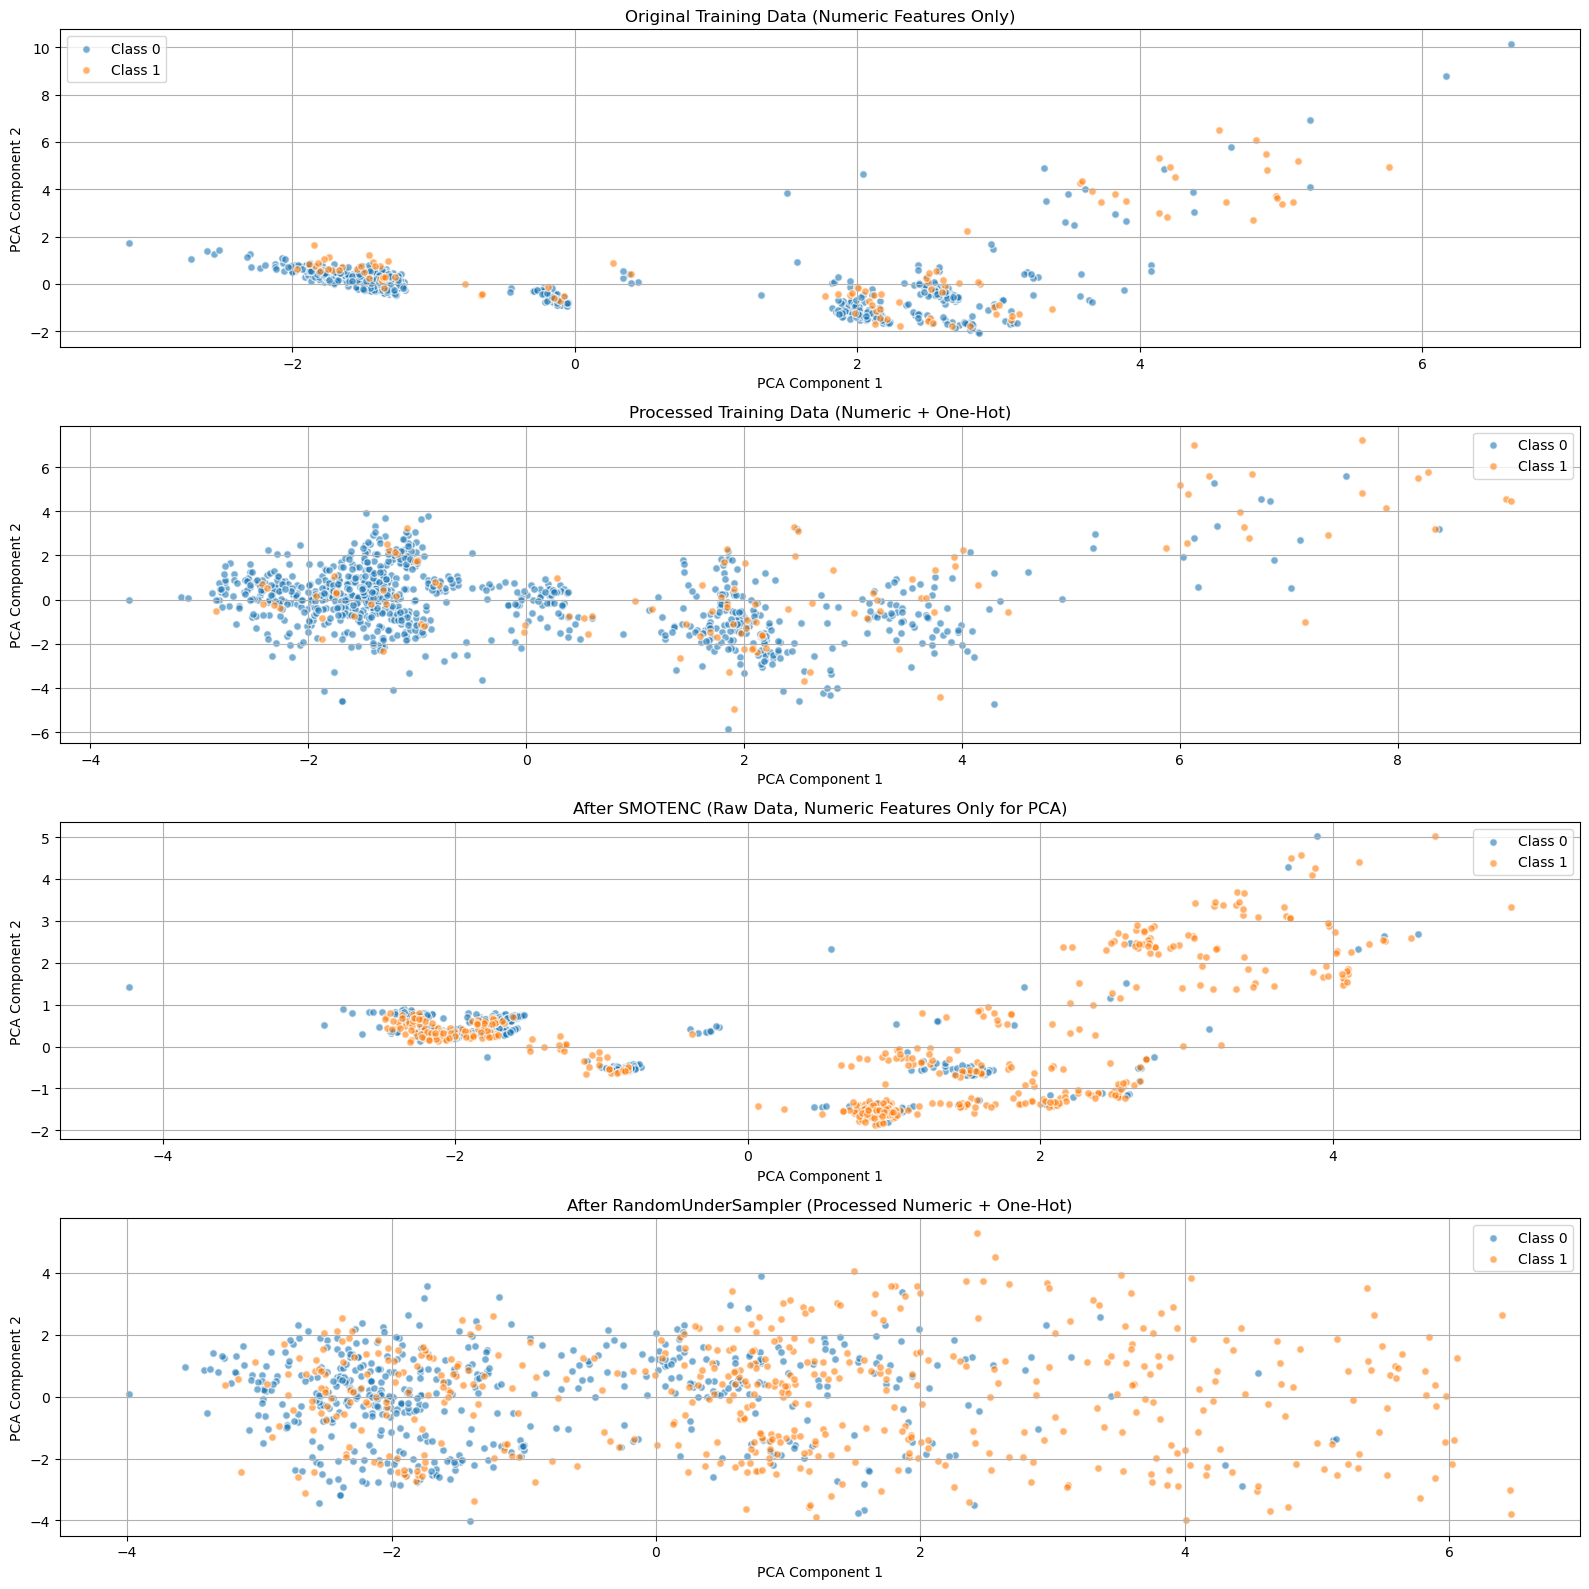

In [23]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

def plot_2d_pca(X_list, y_list, titles, sample_size=1000):
    plt.figure(figsize=(16, 4 * len(X_list)))

    for i, (X, y, title) in enumerate(zip(X_list, y_list, titles), 1):
        # Convert sparse matrix to dense if needed
        if hasattr(X, "toarray"):
            X = X.toarray()

        # Subsample for speed if dataset is too large
        if X.shape[0] > sample_size:
            idx = np.random.choice(X.shape[0], sample_size, replace=False)
            X = X[idx]
            y = y.iloc[idx]  # Use iloc for positional indexing on pandas Series

        # Scale data before PCA
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # PCA with 2 components
        pca = PCA(n_components=2, random_state=42)
        X_pca = pca.fit_transform(X_scaled)

        # Plotting
        plt.subplot(len(X_list), 1, i)
        for cls in np.unique(y):
            plt.scatter(
                X_pca[y == cls, 0], X_pca[y == cls, 1],
                label=f"Class {cls}",
                alpha=0.6, edgecolors='w', s=30
            )
        plt.title(title)
        plt.xlabel("PCA Component 1")
        plt.ylabel("PCA Component 2")
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# Example usage (assuming variables are already defined):

# Extract numeric columns only for PCA on raw data (for smote_nc and original)
X_train_numeric = X_train[NumCols].values

# For smote_nc output (raw data), select numeric cols for PCA
X_train_smote_nc_numeric = (
    X_train_smote_nc[NumCols].values if hasattr(X_train_smote_nc, 'iloc') else X_train_smote_nc[:, :len(NumCols)]
)

X_list = [
    X_train_numeric,
    X_train_processed,
    X_train_smote_nc_numeric,
    X_train_rus
]

y_list = [
    y_train,
    y_train,
    y_smote_nc,
    y_train_rus
]

titles = [
    "Original Training Data (Numeric Features Only)",
    "Processed Training Data (Numeric + One-Hot)",
    "After SMOTENC (Raw Data, Numeric Features Only for PCA)",
    "After RandomUnderSampler (Processed Numeric + One-Hot)"
]

plot_2d_pca(X_list, y_list, titles)


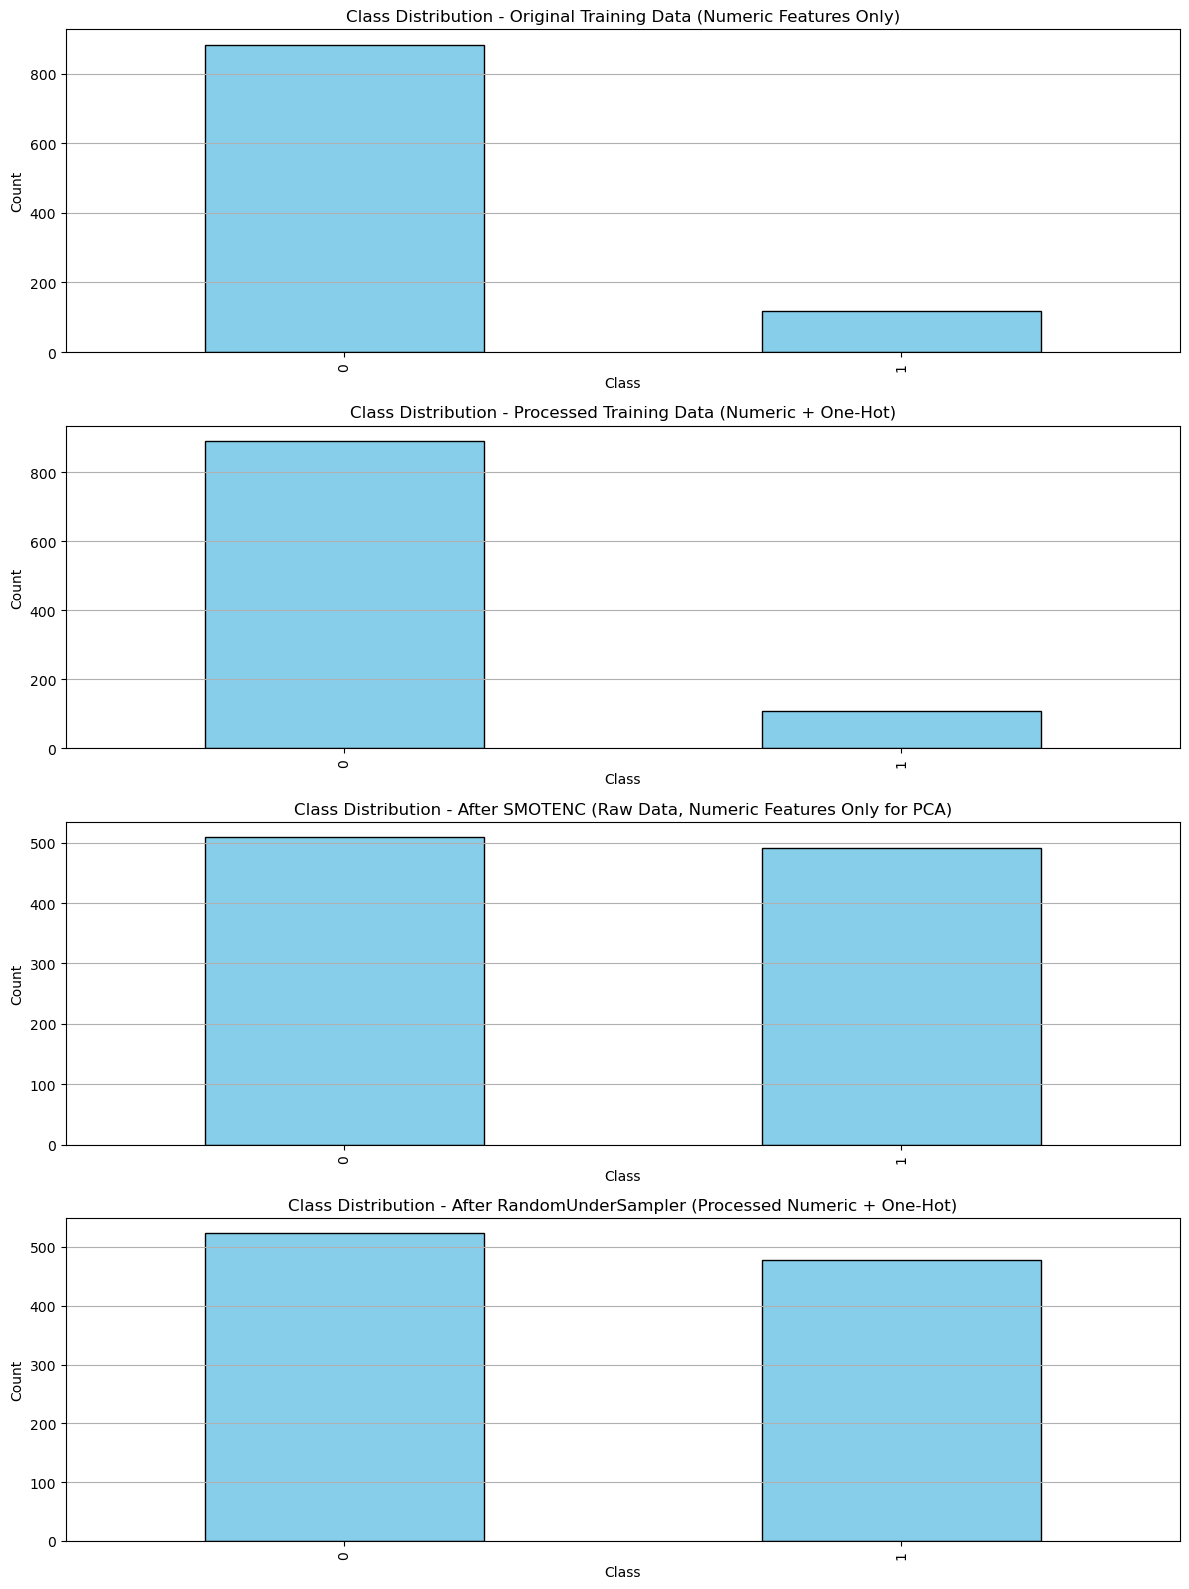

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_class_distribution_bar(X_list, y_list, titles, sample_size=1000):
    plt.figure(figsize=(12, 4 * len(X_list)))

    for i, (X, y, title) in enumerate(zip(X_list, y_list, titles), 1):
        # Subsample for speed if needed
        if X.shape[0] > sample_size:
            idx = np.random.choice(X.shape[0], sample_size, replace=False)
            y_sub = y.iloc[idx] if hasattr(y, "iloc") else y[idx]
        else:
            y_sub = y

        # Count samples per class
        class_counts = pd.Series(y_sub).value_counts().sort_index()

        plt.subplot(len(X_list), 1, i)
        class_counts.plot(kind='bar', color='skyblue', edgecolor='black')
        plt.title(f"Class Distribution - {title}")
        plt.xlabel("Class")
        plt.ylabel("Count")
        plt.grid(axis='y')

    plt.tight_layout()
    plt.show()


# Usage (same variables assumed defined as before):
plot_class_distribution_bar(X_list, y_list, titles)


In [ ]:
X_train = X_train
X_train_smote_nc = X_train_smote_nc
X_train_smote = X_train_smote
X_train_rus = X_train_rus
y_train = y_train
y_smote_nc = y_smote_nc
y_train_smote = y_train_smote
y_train_rus = y_train_rus

# Modelling

## Model Building

### Common functions for reproducibility

### Base model

In [ ]:
dt_model = DecisionTreeClassifier(random_state=42)
lr_model = LogisticRegression(random_state=42, max_iter=1000)

### Models with sampling method 1

### Models with sampling method 2

### Models with sampling method 3

### Models with sampling method 4

This final sampling method is a hybrid method of sampling which combines SMOTE-NC and RUS

https://www.mdpi.com/2078-2489/14/1/54

#### SMOTE-NC

In [ ]:
# Identify categorical columns (indices)
categorical_features = X.select_dtypes(include=['object', 'category']).columns
categorical_indices = [X.columns.get_loc(col) for col in categorical_features]

# Initialize SMOTE-NC
desired_ratio = 0.8  # example: make minority class 80% of majority
smote_nc = SMOTENC(categorical_features=categorical_indices, sampling_strategy=desired_ratio, k_neighbors=5, random_state=42)

# Fit and resample
X_resampled, y_resampled = smote_nc.fit_resample(X, y)

#### RUS

In [ ]:
# Initialize RUS to match minority class count
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Apply undersampling
X_hybrid, y_hybrid = rus.fit_resample(X_resampled, y_resampled)


### Visualize the differences

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6), ncols=3, nrows=1)

# Original y distribution
sns.countplot(x=y, ax=ax[0])
ax[0].set_title('Original y Distribution')

# Resampled y distribution after SMOTE-NC
sns.countplot(x=y_resampled, ax=ax[1])
ax[1].set_title('y Distribution after SMOTE-NC')

# Final y distribution after undersampling
sns.countplot(x=y_hybrid, ax=ax[2])
ax[2].set_title('y Distribution after Undersampling')
plt.tight_layout()
plt.show()


## Model Validation and Hyperparameter Tuning

## Model Evaluation

# Implications

In [1]:
test

NameError: name 'test' is not defined

# 